# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive-beta.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.metrics.cluster import normalized_mutual_info_score
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
#load the data
FFILE = './data_banknote_authentication.txt'
if os.path.isfile(FFILE): 
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.githubusercontent.com/antalbe001/Challenge/main/data_banknote_authentication.txt"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.githubusercontent.com/antalbe001/Challenge/main/data_banknote_authentication.txt"

File already exists
File is readable


In [ ]:
# import txt dataset
data = pd.read_csv('https://raw.githubusercontent.com/antalbe001/Challenge/main/data_banknote_authentication.txt?token=GHSAT0AAAAAAB4SSEBZZUU54B6HMXMAQ7DUY5BSS2A', header=None)
data = data.rename(columns = {0: 'variance', 1: 'skewness', 2: 'curtosis', 3: 'entropy', 4: 'label'})
data = data.sample(frac=1,random_state=0).reset_index(drop=True) # random shuffle
data.head()

,variance,skewness,curtosis,entropy,label
0,-1.7713,-10.766500,10.21840,-1.00430,1
1,5.1321,-0.031048,0.32616,1.11510,0
2,-2.0149,3.687400,-1.93850,-3.89180,1
3,1.4884,3.627400,3.30800,0.48921,0
4,5.2868,3.257000,-1.37210,1.16680,0


In [ ]:
data.isnull()

,variance,skewness,curtosis,entropy,label
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1367,False,False,False,False,False
1368,False,False,False,False,False
1369,False,False,False,False,False
1370,False,False,False,False,False


In [ ]:
data.mean()

variance    0.433735
skewness    1.922353
curtosis    1.397627
entropy    -1.191657
label       0.444606
dtype: float64

In [ ]:
# Transform the data to use it as numpy arrays. 
X = data.iloc[:,:-1]
label = data.iloc[:,4]
print(X.shape)
N = X.shape[0]  # Number of data points
nc = X.shape[1]  # Number of features/components
print(np.unique(label)) 

(1372, 4)
[0 1]


In [ ]:
# Rescale the features of the data since the units are different: substract the average and divide by the standard deviation
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

In [ ]:
#PCA plot 2 components
#K-MEANS 2 classes
#T-SNE for projection
#DBSCAN for clustering

In [ ]:
#PCA
#matrice di covarianza
# C=X^t X
Cov = np.matmul(X_scaled.transpose(), X_scaled)
lamb, v = LA.eigh(Cov)  # autovalori e autovettori
idx = np.argsort(-lamb)
lambs = lamb[idx]
vs = v[:,idx]
print(lambs)
projection = np.matmul(X_scaled, vs)

[2990.82838913 1774.2085225   482.09669946  240.86638891]


In [ ]:
# prportion of variance explained
cumul = np.zeros(nc)
total = np.sum(lambs)
for i in range(nc):
    cumul[i] = np.sum(lambs[:i+1])/total
comp = np.arange(nc) + 1

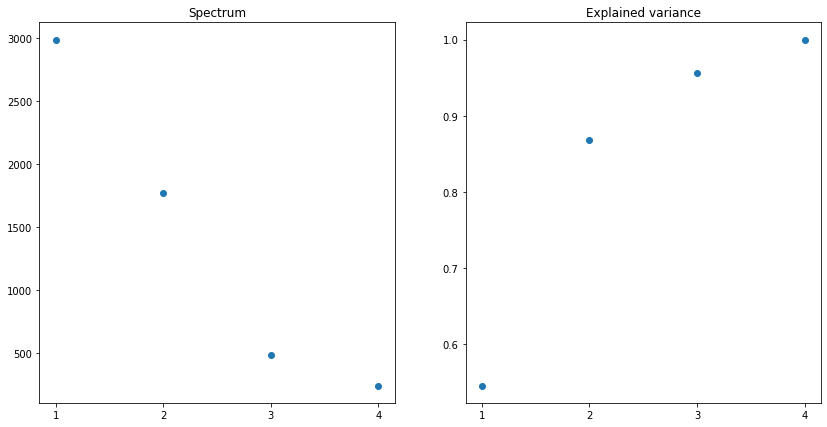

In [ ]:
f, [ax1, ax2] = plt.subplots(1, 2,figsize = (14, 7))
ax1.set_title('Spectrum')
ax1.scatter(comp, lambs)
ax1.set_xticks(comp)
ax2.set_title('Explained variance')
ax2.scatter(comp, cumul)
ax2.set_xticks(comp)
plt.show()

In [ ]:
# Number of components depending on the explained variance threshold.
for t in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    nc = np.argmax(cumul - t > 0.) + 1
    print(t, nc)

0.8 2
0.85 2
0.9 3
0.95 3
0.97 4
0.99 4
0.999 4


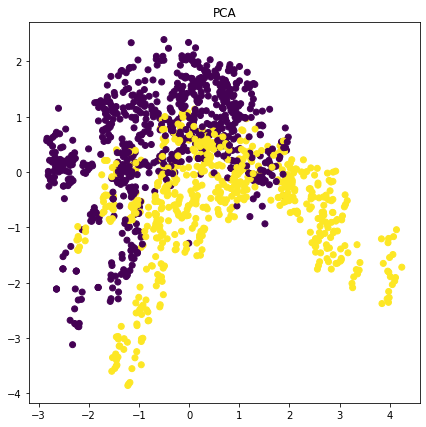

In [ ]:
# plotting the data set in 2D (i.e. keep only 2 PCs) colored by its ground truth label
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0],projection[:,1], c=label)
ax.set_title('PCA')
plt.show()

In [ ]:
#K-MEANS
def k_means_internal(k, X, init):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    '''
    N = X.shape[0] # number of points 
    nc = X.shape[1] # number of coordinates
    ll = np.arange(k) 
    z = np.zeros(N, dtype='int') # cluster number assigned to each data point
    cent = np.zeros([k, nc]) # coordinates of the cluster centers
    # k-means++
    if (init=='++'):
        b = np.random.choice(N, 1, replace=False) # choose the first cluster center at random
        cent[0, :] = X[b, :]
        nchosen = 1 # number of cluster centers already set
        while (nchosen < k):
            dist = cdist(cent[:nchosen, :], X) # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0) # min distance btw point and cluster centers
            prob = dmin**2 
            prob = prob/np.sum(prob) 
            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob) 
            cent[nchosen, :] = X[b,:]
            nchosen = nchosen + 1
    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly 
        for i in ll:
            cent[i, :] = X[b[i],:]
    dist = cdist(cent, X)  # distance of each point from cluster centers 
    z_new = np.argmin(dist, axis=0) # assign each point to cluster with closest center
    dmin = np.min(dist,axis=0)
    niter = 0
    L = np.sum((dmin)**2) # loss function evaluation
    while (z_new != z).any(): # until a stable configuration is reached
        z = np.copy(z_new)
        for i in range(k):
            cent[i, :] = np.average(X[z==i,:],axis=0) # compute cluster centroids
        dist = cdist(cent, X) # update distances from cluster centers
        z_new = np.argmin(dist, axis=0) # find cluster with min centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2) # loss function evaluation
        niter = niter + 1
    return (z_new, L, niter)

In [ ]:
def k_means(k, X, init='++', n_init=20):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    n_init : int
      Number of runs of the algorithms (with different initializations)
    '''
    lmin = 9.9*10**99
    for i in range(n_init):
        labels, loss, niter = k_means_internal(k, X_scaled, init=init)
        if (loss < lmin):  # store the best performing iteration
            lmin = loss
            labels_opt = labels
    return (labels_opt, lmin)

In [ ]:
two_dimension_projection = projection[:,0:2]

In [ ]:
k_labels, k_lmin = k_means(2, two_dimension_projection)

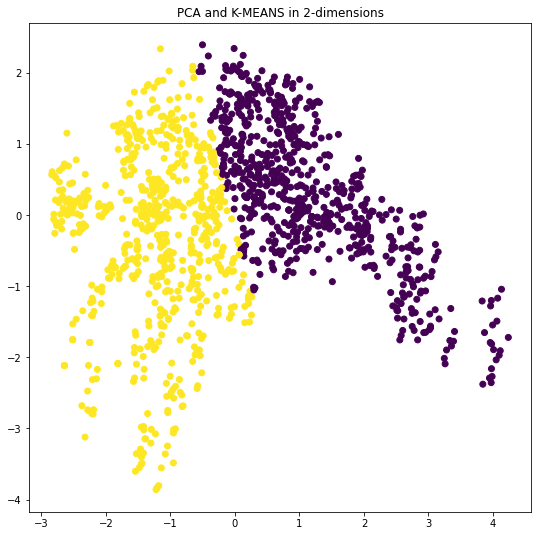

In [ ]:
# Plot the projection according to the k-means clusters
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(two_dimension_projection[:,0], two_dimension_projection[:,1], c=k_labels)
ax.set_title('PCA and K-MEANS in 2-dimensions')
plt.show()

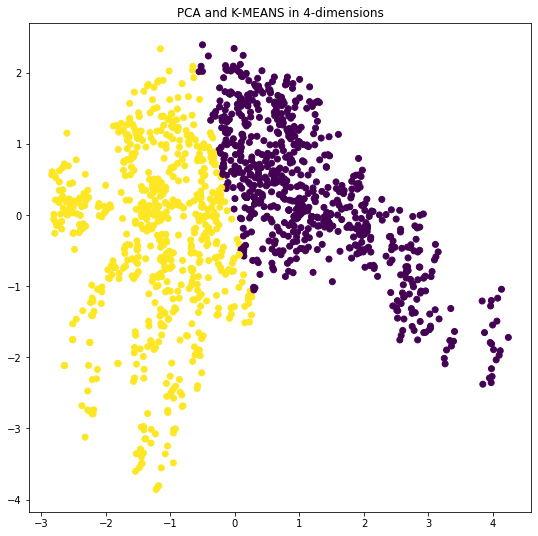

In [ ]:
k_labels2, k_lmin2 = k_means(2, projection)
# Plot the projection according to the k-means clusters
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(projection[:,0],projection[:,1], c=k_labels2)
ax.set_title('PCA and K-MEANS in 4-dimensions')
plt.show()

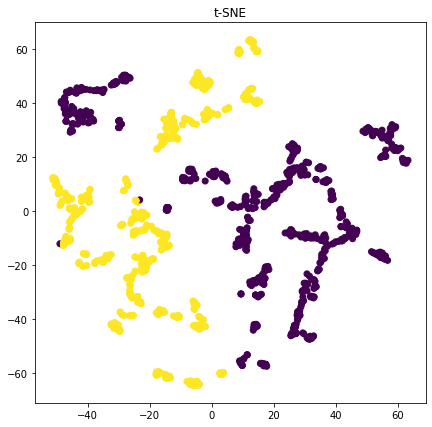

In [ ]:
#TSNE
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(X_scaled)
fig, ax =plt.subplots(figsize=(7,7))
ax.scatter(X_embedded[:,0],X_embedded[:,1], c=label)
ax.set_title('t-SNE')
plt.show()

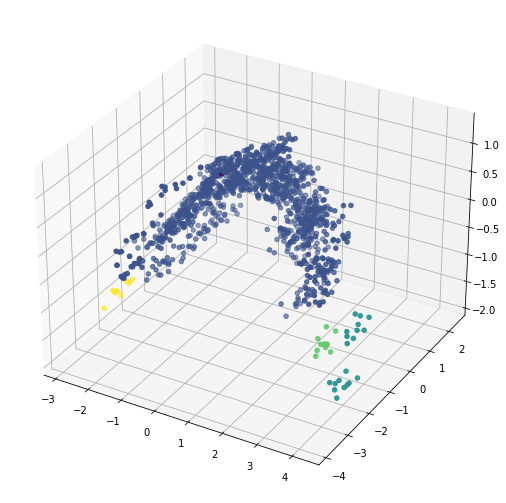

In [ ]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=5).fit(X_scaled)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0],projection[:,1], projection[:,2],c=dbscan.labels_)
plt.show()

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [ ]:
#LOGISTIC REGRESSION
#DECISION TREE CON ID3
#NAIVE BAYES 
#K-NN
#CROSS VALIDATION

In [ ]:
#TRAIN TEST SPLIT E LOGISTIC REGRESSION
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=372, random_state=26, shuffle = False)
log_reg = LogisticRegression(penalty=None).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)

Accuracy:  0.9946236559139785


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.99 1.   1.   0.99 0.98 0.99 0.98 0.97 0.99 1.  ]


In [ ]:
#RIDGE

import numpy.linalg as LA

def sigmoidM(X, w):
    """
    Parameters
    ----------
    X : array of dim n x d 
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    h = 1/(1+np.exp(-np.matmul(X,w)))
    return h


def RidgeLogisticLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w))) + (1/n)*lam*LA.norm(w,2)
    return cost

def RidgeGradient(w, lam, points):
    return ((1/points)*2*lam*w)

def LogisticGradient(X,y,w, points):
    d = np.shape(X)
    return (1/points)*(np.transpose(X)@(sigmoidM(X,w)-y))

    
def GDRidge(X, y, iter, gamma, lam, points):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the L2 penalty term
    points : int
        Number of points in our dataset

    """
    d = np.shape(X)[1]
    W = np.zeros((d,iter)) #matrice pesi
    L = np.zeros(iter) #vettore loss
    w = np.random.normal(0,0.1,d)
    #w = np.zeros(d)
    for i in range(iter):
        W[:,i] = w
        w = w - 2*gamma*(LogisticGradient(X, y, w, points) + RidgeGradient(w, lam, points))
        L[i] = RidgeLogisticLoss(X,y,w,lam)
    return W, L

In [ ]:
#LASSO

def LassoLogisticLoss(X,y,w,lam):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    
    n = np.shape(X)[0]
    L = -(1/n)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w))) + (1/n)*lam*LA.norm(w,1)
    return L

def L1_subgradient(z):
    g = np.ones(z.shape)
    g[z < 0.] = -1.0
    return g

def LassoGradient(w, lam, points):
    return (lam * L1_subgradient(w))/points
    
def GDLasso(X, y, iter, gamma, d, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    lam : float
        Weight of the L1 penalty term
    """
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    w = np.zeros(d)
    for i in range(iter):
        W[:,i] = w
        w = w - 2*gamma*(LogisticGradient(X, y, w, points) + LassoGradient(w, lam, points))
        L[i] = LassoLogisticLoss(X,y,w,lam)
    return W, L

In [ ]:
#ELASTIC NET

def ElasticLogisticLoss(X,y,w,lam,alpha):
    n = np.shape(X)[0]
    L = -(1/n)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w)))
    penaltyl1 = LA.norm(w,1)/n
    penaltyl2 = LA.norm(w,2)/n
    cost = L + lam*(alpha*penaltyl1 +(1-alpha)*penaltyl2)
    return cost

def ElasticGradient(w, lam,alpha,points):
    return alpha*LassoGradient(w,lam,points)+(1-alpha)*RidgeGradient(w,lam,points)

def ElasticGDLogistic(X, y, iter, gamma,lam,alpha): 
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the L2 penalty term
    """
    d = np.shape(X)
    L = np.zeros(iter)
    w = np.zeros(d[1])
    W = np.zeros((d[1],iter))
    for i in range(iter):
        W[:,i] = w
        w = w-2*gamma*(LogisticGradient(X,y,w,d[0]) + ElasticGradient(w, lam, alpha, d[0]))
        L[i] = ElasticLogisticLoss(X,y,w,lam,alpha)
    return W,L 

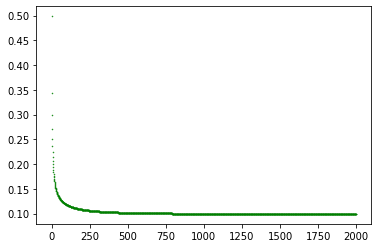

In [ ]:
w_trial,l_trial = ElasticGDLogistic(X, label, 2000, 0.1, 0.4, 0.5)


fig, ax = plt.subplots()
ax.plot(l_trial, 'go', markersize=0.5)
fig.show()

In [ ]:
from sklearn.metrics import classification_report
wEN,cEN = ElasticGDLogistic(X_train,y_train,2000,0.1,0.4,0.5)
pesiEN = wEN[:,-1]
previsioniEN = sigmoidM(X_test,pesiEN)

yEN_true = y_test 
yEN_pred = np.round(previsioniEN)

target_names = ['0', '1']
print(classification_report(yEN_true, yEN_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       194
           1       1.00      0.86      0.92       178

    accuracy                           0.93       372
   macro avg       0.94      0.93      0.93       372
weighted avg       0.94      0.93      0.93       372



### Decision Tree

In [ ]:
train_data = data.iloc[:1000,:]
test_data = data.iloc[1000:,:]
print(train_data.shape)
print(test_data.shape)

(1000, 5)
(372, 5)


In [ ]:
# normalize train and test dataset 
from sklearn import preprocessing
label_train = train_data['label']
train_data = train_data.drop('label', axis=1)
columns_name = train_data.columns
#train_scaler = preprocessing.StandardScaler().fit(train_data)
#train_data = train_scaler.transform(train_data)
train_data = pd.DataFrame(train_data, columns=columns_name)
train_data['label'] = label_train.values
label_test = test_data['label']
test_data = test_data.drop('label', axis=1)
#test_scaler = preprocessing.StandardScaler().fit(test_data)
#test_data = test_scaler.transform(test_data)
test_data = pd.DataFrame(test_data, columns=columns_name)
test_data['label'] = label_test.values

In [ ]:
# compute H(S)
def entropy(train_data, label, class_list):
    total_row = train_data.shape[0]  # the total size of the dataset  
    total_entr = 0
    for c in class_list:  # for each possible class in the label
        total_class_count = train_data[train_data[label] == c].shape[0]  # number of points belonging to the class
        if total_class_count > 0:
          total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row)  # entropy of the class
          total_entr += total_class_entr  # adding the class entropy to the total entropy of the dataset
    return total_entr

In [ ]:
# compute H(S_j)
def feature_entropy(left_data, right_data, label, class_list):
    row_count = left_data.shape[0] + right_data.shape[0] # n points considered
    p_left = left_data.shape[0] / row_count
    p_right = right_data.shape[0] / row_count
    ent = p_left * entropy(left_data, label, class_list) + p_right * entropy(right_data, label, class_list)
    return ent

In [ ]:
def split(feature_column, threshold):
  left_rows = np.argwhere(feature_column <= threshold).flatten()
  right_rows = np.argwhere(feature_column > threshold).flatten()
  return left_rows, right_rows

In [ ]:
def information_gain(data, feature_name, label, class_list, threshold):
  left_rows, right_rows = split(data[feature_name].values, threshold)
  if len(left_rows)==0 or len(right_rows)==0:
    return 0
  feat_entropy = feature_entropy(data.iloc[left_rows], data.iloc[right_rows], label, class_list)
  return feat_entropy

In [ ]:
def get_split_thresholds(feature_column, n_thresholds):
  feature_column = feature_column.values
  n_data = len(feature_column)
  sorted_column = np.sort(feature_column)
  if len(feature_column) > 1:
    partitioned_array = np.array_split(feature_column, n_thresholds + 1)
    thresholds = [(partitioned_array[i][-1] + partitioned_array[i+1][0])/2 for i in range(len(partitioned_array)-1)]
  else:
    thresholds = [feature_column[0]]
  return thresholds

In [ ]:
def most_informative_feature(train_data, label, class_list, n_thresholds):
    feature_list = train_data.columns.drop(label)
    min_entropy = 99999
    min_entropy_feature = None
    min_entropy_threshold = None
    for feature in feature_list:
      thresholds = get_split_thresholds(train_data[feature], n_thresholds)
      for t in thresholds:
        info_gain = information_gain(train_data, feature, label, class_list, t)
        if info_gain < min_entropy:
          min_entropy = info_gain
          min_entropy_feature = feature
          min_entropy_threshold = t
    return min_entropy_feature, min_entropy_threshold

In [ ]:
def is_leaf(train_data, label):
  classes_in_node = np.unique(train_data[label])
  if len(classes_in_node) == 1:
    return True
  else:
    return False

In [ ]:
def leaf_class(train_data, label):
    class_list, count_class = np.unique(train_data[label], return_counts=True)
    idx = count_class.argmax()
    return class_list[idx]

In [ ]:
def make_tree(train_data, label, class_list, n_thresholds, cur_depth, min_samples, max_depth):
  if is_leaf(data, label) or cur_depth>=max_depth or len(train_data)<=min_samples:
    return leaf_class(train_data, label)
  else:
    cur_depth += 1
    split_feature, split_threshold = most_informative_feature(train_data, label, class_list, n_thresholds)
    left_rows, right_rows = split(train_data[split_feature].values, split_threshold)
    if len(left_rows)==0 or len(right_rows)==0:
      return leaf_class(train_data, label)
    else:
      # build sub tree
      split_condition = "{} <= {}".format(split_feature, split_threshold)
      sub_tree = {split_condition : []}
      # recursive call
      left_branch = make_tree(train_data.iloc[left_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
      right_branch = make_tree(train_data.iloc[right_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
      if left_branch == right_branch:
        sub_tree = left_branch
      else:
        # grow the tree
        sub_tree[split_condition].append(left_branch)
        sub_tree[split_condition].append(right_branch)
      return sub_tree

In [ ]:
# id3 call
def id3(train_data_m, label, n_thresholds=1, min_samples=4, max_depth=6):
    train_data = train_data_m.copy()  # getting a copy of the dataset
    class_list = train_data['label'].unique()  # getting unqiue classes of the label
    tree = make_tree(train_data, label, class_list, n_thresholds, 0, min_samples, max_depth)  # start calling recursion
    return tree

In [ ]:
def predict(test_point, tree):
    if not isinstance(tree, dict):
      return tree
    question = list(tree.keys())[0]
    attribute, value = question.split(" <= ")
    if test_point[attribute] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
    return predict(test_point, answer)

def evaluate(tree, test_data, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index in range(len(test_data.index)):  # for each row in the dataset
        result = predict(test_data.iloc[index], tree)  # predict the row
        if result == test_data[label].iloc[index]:  # predicted value and expected value is same or not
            correct_preditct += 1  # increase correct count
        else:
            wrong_preditct += 1  # increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)  # calculating accuracy
    return accuracy

In [ ]:
t = id3(train_data, 'label')
id3_accuracy = evaluate(t, test_data, 'label')
id3_accuracy

0.9811827956989247

### Naive Bayesian


In [ ]:
def prior(train_data, label):
  priors = train_data.groupby(by=label).apply(lambda x: len(x)/len(train_data))
  return np.log(priors).values

def mean_variance(train_data, label):
  mean = train_data.groupby(by=label).apply(lambda x: x.mean(axis=0))
  variance = train_data.groupby(by=label).apply(lambda x: x.var(axis=0))
  return (mean.values, variance.values)

def gaussian_density(mean, variance, point):
  d = (1 / np.sqrt(2*np.pi*variance)) * np.exp((-(point - mean)**2) / (2*variance))
  return d

def train_gaussian_naive_bayes(train_data, label):
  mean, variance = mean_variance(train_data, label)
  priors = prior(train_data, label)
  unique_labels = train_data[label].unique()
  n_labels = len(unique_labels)
  return {'n_labels': n_labels, 'unique_labels': unique_labels, 'n_classes': n_labels, 'mean': mean, 
          'variance': variance, 'prior': priors}

In [ ]:
def posterior(point, mean, variance, class_list, n_classes, n_feat):
  posteriors = []
  for i in range(n_classes):
    posterior = 0
    for j in range(n_feat):
      posterior += np.log(gaussian_density(mean[i][j], variance[i][j], point[j]))
    posteriors.append(posterior)
  return posteriors

def predict(test_data, label, gaus_bayes):
  predictions = []
  n_feat = len(test_data.columns) - 1
  for i in range(len(test_data)):
    pr = gaus_bayes['prior']
    post = posterior(test_data.iloc[i, :-1], gaus_bayes['mean'], gaus_bayes['variance'], 
                     gaus_bayes['unique_labels'], gaus_bayes['n_classes'], n_feat)
    prob = pr + post
    max_prob_class_idx = np.argmax(prob)
    predictions.append(gaus_bayes['unique_labels'][max_prob_class_idx])
  return predictions 

def evaluate(test_data, label, gaus_bayes):
  gaus_pred = predict(test_data, label, gaus_bayes)
  correct_predict = 0
  wrong_predict = 0
  for index in range(len(test_data.index)):  # for each row in the dataset
        if gaus_pred[index] == test_data[label].iloc[index]:  # predicted value and expected value is same or not
            correct_predict += 1  # increase correct count
        else:
            wrong_predict += 1  # increase incorrect count
  accuracy = correct_predict / (correct_predict + wrong_predict)  # calculating accuracy
  return accuracy

In [ ]:
def KFoldBayes(train,K,label):
    """
    Parameters
    ----------
    Xtr : matrix of float of dim n x d
        Dataset
    Ytr : array of float of dim n
        Ground truth values
    K : int
        Number of folds to split the data into
    lam : array of float 
        Tuning hyperparameter under analysis
    """
    points = train.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    rand_idx = np.random.choice(points, size=points, replace=False)
    results = np.zeros(K)
   
    first = 0
    for fold in range(K):
            flags = np.zeros(points) 
            flags[first:first + fold_size] = 1;  
            X = train.iloc[rand_idx[flags==0]]
            X_val = train.iloc[rand_idx[flags==1]]
            bayes_model = train_gaussian_naive_bayes(X, label)
            results[fold]=evaluate(X_val, label, bayes_model)

            first = first + fold_size                

    return results

In [ ]:
res_k = KFoldBayes(train_data,6,'label')
res_k

array([0.19161677, 0.16766467, 0.19161677, 0.17964072, 0.16766467,
       0.17575758])

kNN

In [ ]:
from scipy.spatial.distance import euclidean

def distance(point_one, point_two):
    return euclidean(point_one, point_two)

def get_neighbors(train_set, test_point, label_col, n_neighbors):
  dist = np.array([distance(train_point, test_point) for train_point in train_set])
  idx_dist = dist.argsort()
  ordered_train = train_set[idx_dist, :]
  ordered_label = label_col[idx_dist]
  return ordered_train[:n_neighbors], ordered_label[:n_neighbors]

def predict(train_set, test_point, labels, n_neighbors):
  neigh, neigh_label = get_neighbors(train_set, test_point, labels, n_neighbors)
  values, counts = np.unique(neigh_label, return_counts=True)
  idx = np.argmax(counts)
  return values[idx]

def evaluate(train_set, test_set, label, n_neighbors=2):
    correct_preditct = 0
    wrong_preditct = 0
    train_labels = train_set[label].values
    train_set = train_set.drop(label, axis=1)
    test_labels = test_set[label].values
    test_set = test_set.drop(label, axis=1)
    for index in range(len(test_set.index)):  # for each row in the dataset
        result = predict(train_set.values, test_set.iloc[index].values, train_labels, n_neighbors)  # predict the row
        if result == test_labels[index]:  # predicted value and expected value is same or not
            correct_preditct += 1  # increase correct count
        else:
            wrong_preditct += 1  # increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)  # calculating accuracy
    return accuracy

In [ ]:
knn_accuracy = evaluate(train_data, test_data, 'label')
knn_accuracy

1.0

In [ ]:
def KFoldCVKNN(dataset, K_folds, K, classe):
    """
    Parameters
    ----------
    dataset : matrix of dim n x d
        Dataset
    K_folds : int
        Number of folds to split the data into
    K : array of int
        Tuning hyperparameter under analysis

    """
    num_hpar = len(K) # number of possible values for the hyperparameter
    points = dataset.shape[0] # total training points
    fold_size = int(np.ceil(points/K_folds)) # size of each K-fold
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_accuracy_mean = np.zeros(num_hpar)
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    
    
    val_acc = np.zeros((num_hpar,K_folds))
   
    # loop across all hyperparameters values
    for l_idx, l in enumerate(K): 
        print(l)
        first = 0
        # K-fold CV runs
        for fold in range(K_folds):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points) 
            flags[first:first + fold_size] = 1;  
            
            # construct the  training and validation set      
            X_ = dataset.iloc[rand_idx[flags==0]]
            
            X_val = dataset.iloc[rand_idx[flags==1]]
                            
            
            # compute the accuracy
            
                                  
            val_accuracy = evaluate(X_,X_val,classe)
            
            
            val_acc[l_idx, fold] = val_accuracy
            
            # update the first position to select the next fold
            first = first + fold_size 
            

        # summarize performance metrics
        
        val_accuracy_mean[l_idx] = np.mean(val_acc[l_idx,:])
        
        print(val_accuracy_mean[l_idx])
        
       
        val_std[l_idx] = np.std(val_acc[l_idx,:])
    
    best_par_idx = np.argmax(val_accuracy_mean)
    best_par = K[best_par_idx]

    return val_accuracy_mean, val_std


In [ ]:
k=5
par = np.linspace(2,10,9)
KFoldCVKNN(train_data, k, par, 'label')

2.0
1.0
3.0
1.0
4.0
1.0
5.0


KeyboardInterrupt: ignored